In [1]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary
from torchvision.utils import save_image
import pandas as pd 
from matplotlib import pyplot

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Nov 26 17:10:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    41W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


# PARAMETERS

In [4]:
MNIST_BATCH_SIZE = 100
CIFAR10_BATCH_SIZE = 100
MNIST_EPOCHS = 30
CIFAR10_EPOCHS = 200

# IMPORTING DATA

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### MNIST

- Each img: (1,28,28)
- Training: 60,000
- Testing: 10,000


### CIFAR10

- Each img: (3,32,32)
- Training: 50, 000
- Testing: 10,000

In [6]:
mnist_training = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(),
    download=True,
)

mnist_testing = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor(),
)

datasets.CIFAR10.url="http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

cifar10_training = datasets.CIFAR10(
    root = 'data',
    train = True,                         
    transform = ToTensor(),
    download=True,
)

cifar10_testing = datasets.CIFAR10(
    root = 'data', 
    train = False, 
    transform = ToTensor(), 
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data


In [7]:
# Data Loaders

mnist_data_loader = {
    'train' : DataLoader(mnist_training, batch_size=MNIST_BATCH_SIZE, shuffle=True, num_workers=1),
    'test'  : DataLoader(mnist_testing, batch_size=MNIST_BATCH_SIZE, shuffle=True, num_workers=1),
}

cifar10_data_loader = {
    'train' : DataLoader(cifar10_training, batch_size=CIFAR10_BATCH_SIZE, shuffle=True, num_workers=1),
    'test'  : DataLoader(cifar10_testing, batch_size=CIFAR10_BATCH_SIZE, shuffle=True, num_workers=1),
}

# HELPER FUNCTIONS

In [18]:
def displayMNIST(dataset, index, save=False, title="Title"):
    
    display_img = dataset.data[index]
    display_lab = dataset.targets[index].numpy()
    
    fig, ax = plt.subplots(1)
    ax.imshow(display_img, cmap='gray')
    ax.text(2,2, 'Label='+str(display_lab), bbox={'facecolor': 'white', 'pad': 2}, fontsize=12)
    plt.axis('off')
    
    if save: plt.savefig(title+'.png')

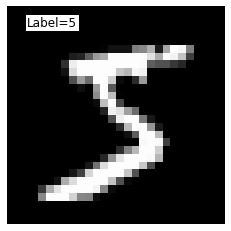

In [19]:
displayMNIST(mnist_training, 0)

In [20]:
def decodeCIFARLabel(target):
    
    return ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'][target]

In [21]:
def displayCIFAR10(dataset, index, save=False, title="Title"):
    
    display_img = dataset.data[index]
    display_lab = dataset.targets[index]
    
    fig, ax = plt.subplots(1)
    ax.imshow(display_img, cmap='gray', interpolation='nearest')
    ax.text(2,2, 'Label='+str(display_lab)+" ("+decodeCIFARLabel(display_lab)+")", bbox={'facecolor': 'white', 'pad': 2}, fontsize=12)
    plt.axis('off')
    
    if save: plt.savefig(title+'.png')

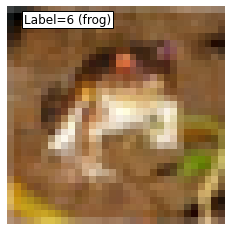

In [22]:
displayCIFAR10(cifar10_training, 0)

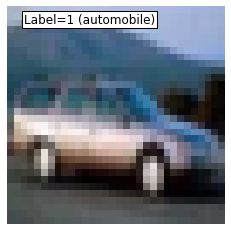

In [23]:
displayCIFAR10(cifar10_training, 4)

# DIFFERENT VAE ARCHITECTURES

In [24]:
# Reference: https://github.com/lyeoni/pytorch-mnist-VAE

class VAE2(nn.Module):
    def __init__(self, img_dim, latent_size):
        
        super(VAE2, self).__init__()
        
        x_dim = img_dim * img_dim
        h_dim1 = 512
        h_dim2 = 256
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, latent_size)
        self.fc32 = nn.Linear(h_dim2, latent_size)
        
        # decoder part
        self.fc4 = nn.Linear(latent_size, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return torch.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        x_dim = x.shape[2] ** 2
        mu, log_var = self.encoder(x.view(-1, x_dim))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var
    
#vae2_latent2 = VAE2(latent_size=2)
#summary(vae2_latent2, (1,28,28))

In [25]:
# Reference: https://github.com/lyeoni/pytorch-mnist-VAE

class VAE3(nn.Module):
    def __init__(self, img_dim, latent_size):
        
        super(VAE3, self).__init__()
        
        x_dim = img_dim * img_dim
        h_dim1 = 1024
        h_dim2 = 512
        h_dim3 = 256
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc3 = nn.Linear(h_dim2, h_dim3)
        self.fc41 = nn.Linear(h_dim3, latent_size)
        self.fc42 = nn.Linear(h_dim3, latent_size)
        
        # decoder part
        self.fc5 = nn.Linear(latent_size, h_dim3)
        self.fc6 = nn.Linear(h_dim3, h_dim2)
        self.fc7 = nn.Linear(h_dim2, h_dim1)
        self.fc8 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        return self.fc41(h), self.fc42(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc5(z))
        h = F.relu(self.fc6(h))
        h = F.relu(self.fc7(h))
        return torch.sigmoid(self.fc8(h)) 
    
    def forward(self, x):
        x_dim = x.shape[2] ** 2
        mu, log_var = self.encoder(x.view(-1, x_dim))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var
    
#vae3_latent5 = VAE3(img_dim=32, latent_size=5)
#summary(vae3_latent5, (3,32,32))

In [26]:
# Reference: https://github.com/lyeoni/pytorch-mnist-VAE

class VAE4(nn.Module):
    def __init__(self, img_dim, latent_size):
        
        super(VAE4, self).__init__()
        
        x_dim = img_dim * img_dim
        h_dim1 = 2048
        h_dim2 = 1024
        h_dim3 = 512
        h_dim4 = 256
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc3 = nn.Linear(h_dim2, h_dim3)
        self.fc4 = nn.Linear(h_dim3, h_dim4)
        self.fc51 = nn.Linear(h_dim4, latent_size)
        self.fc52 = nn.Linear(h_dim4, latent_size)
        
        # decoder part
        self.fc5 = nn.Linear(latent_size, h_dim4)
        self.fc6 = nn.Linear(h_dim4, h_dim3)
        self.fc7 = nn.Linear(h_dim3, h_dim2)
        self.fc8 = nn.Linear(h_dim2, h_dim1)
        self.fc9 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        h = F.relu(self.fc4(h))
        return self.fc51(h), self.fc52(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc5(z))
        h = F.relu(self.fc6(h))
        h = F.relu(self.fc7(h))
        h = F.relu(self.fc8(h))
        return torch.sigmoid(self.fc9(h)) 
    
    def forward(self, x):
        x_dim = x.shape[2] ** 2
        mu, log_var = self.encoder(x.view(-1, x_dim))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

vae4_latent5 = VAE4(latent_size=5, img_dim=28)
vae4_latent5.cuda()
summary(vae4_latent5, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2048]       1,607,680
            Linear-2                 [-1, 1024]       2,098,176
            Linear-3                  [-1, 512]         524,800
            Linear-4                  [-1, 256]         131,328
            Linear-5                    [-1, 5]           1,285
            Linear-6                    [-1, 5]           1,285
            Linear-7                  [-1, 256]           1,536
            Linear-8                  [-1, 512]         131,584
            Linear-9                 [-1, 1024]         525,312
           Linear-10                 [-1, 2048]       2,099,200
           Linear-11                  [-1, 784]       1,606,416
Total params: 8,728,602
Trainable params: 8,728,602
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

In [27]:
# Reference: https://github.com/SashaMalysheva/Pytorch-VAE/blob/master/model.py

class ConvVAE2(nn.Module):
    def __init__(self, img_dim, latent_size, channels):
        
        super(ConvVAE2, self).__init__()

        self.kernel_num = 128
        self.volume = self.kernel_num * ((img_dim // 8) ** 2)
        self.img_dim = img_dim
        
        # encoder part
        self.conv1 =  nn.Conv2d(channels, self.kernel_num // 2, kernel_size=4, stride=2, padding=1)
        self.conv2 =  nn.Conv2d(self.kernel_num // 2, self.kernel_num, kernel_size=4, stride=2, padding=1)

        self.fc31 = nn.Linear(self.volume, latent_size)
        self.fc32 = nn.Linear(self.volume, latent_size)
        
        # decoder part
        self.project = nn.Linear(latent_size, self.volume)
        self.conv5 = nn.ConvTranspose2d(8, self.kernel_num // 2, kernel_size=4, stride=2, padding=1)
        self.conv6 = nn.ConvTranspose2d(self.kernel_num // 2, channels, kernel_size=4, stride=2, padding=1)
        self.fc7 = nn.MaxPool2d(4, 4)
        
        
    def encoder(self, x):
        h = F.relu(self.conv1(x))
        h = F.relu(self.conv2(h))

        h_enrolled = h.view(-1, self.volume)       
        mu = self.fc31(h_enrolled)
        log_var = self.fc32(h_enrolled)

        return mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
        
    def decoder(self, z):
        h = self.project(z)
        h = h.view(-1, 8, self.img_dim, self.img_dim)
        h = F.relu(self.conv5(h))
        h = F.relu(self.conv6(h))
        h = F.relu(self.fc7(h))
        h = torch.sigmoid(h)
        return h
    
    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.sampling(mu, log_var)
        
        return self.decoder(z), mu, log_var
    
vae2_latent2 = ConvVAE2(latent_size=2, img_dim=32, channels=3)
vae2_latent2.cuda()
summary(vae2_latent2, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           3,136
            Conv2d-2            [-1, 128, 8, 8]         131,200
            Linear-3                    [-1, 2]           4,098
            Linear-4                    [-1, 2]           4,098
            Linear-5                 [-1, 2048]           6,144
   ConvTranspose2d-6           [-1, 64, 64, 64]           8,256
   ConvTranspose2d-7          [-1, 3, 128, 128]           3,075
         MaxPool2d-8            [-1, 3, 32, 32]               0
Total params: 160,007
Trainable params: 160,007
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 2.60
Params size (MB): 0.61
Estimated Total Size (MB): 3.22
----------------------------------------------------------------


In [28]:
# Reference: https://github.com/SashaMalysheva/Pytorch-VAE/blob/master/model.py

class ConvVAE3(nn.Module):
    def __init__(self, img_dim, latent_size, channels):
        
        super(ConvVAE3, self).__init__()

        self.kernel_num = 256
        self.volume = self.kernel_num * ((img_dim // 8) ** 2)
        self.img_dim = img_dim
        
        # encoder part
        self.conv1 =  nn.Conv2d(channels, self.kernel_num // 4, kernel_size=4, stride=2, padding=1)
        self.conv2 =  nn.Conv2d(self.kernel_num // 4, self.kernel_num // 2, kernel_size=4, stride=2, padding=1)
        self.conv3 =  nn.Conv2d(self.kernel_num // 2, self.kernel_num, kernel_size=4, stride=2, padding=1)

        self.fc31 = nn.Linear(self.volume, latent_size)
        self.fc32 = nn.Linear(self.volume, latent_size)
        
        # decoder part
        self.project = nn.Linear(latent_size, self.volume)
        self.conv5 = nn.ConvTranspose2d(8, self.kernel_num // 4, kernel_size=4, stride=2, padding=1)
        self.conv6 = nn.ConvTranspose2d(self.kernel_num // 4, self.kernel_num // 2, kernel_size=4, stride=2, padding=1)
        self.conv7 = nn.ConvTranspose2d(self.kernel_num // 2, channels, kernel_size=4, stride=2, padding=1)
        self.fc8 = nn.MaxPool2d(8, 8)
        
        
    def encoder(self, x):
        h = F.relu(self.conv1(x))
        h = F.relu(self.conv2(h))
        h = F.relu(self.conv3(h))

        h_enrolled = h.view(-1, self.volume)       
        mu = self.fc31(h_enrolled)
        log_var = self.fc32(h_enrolled)

        return mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
        
    def decoder(self, z):
        h = self.project(z)
        h = h.view(-1, 8, self.img_dim, self.img_dim)
        h = F.relu(self.conv5(h))
        h = F.relu(self.conv6(h))
        h = F.relu(self.conv7(h))
        h = F.relu(self.fc8(h))
        h = torch.sigmoid(h)
        return h
    
    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.sampling(mu, log_var)
        
        return self.decoder(z), mu, log_var
    
vae3_latent5 = ConvVAE2(latent_size=5, img_dim=32, channels=3)
vae3_latent5.cuda()
summary(vae3_latent5, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           3,136
            Conv2d-2            [-1, 128, 8, 8]         131,200
            Linear-3                    [-1, 5]          10,245
            Linear-4                    [-1, 5]          10,245
            Linear-5                 [-1, 2048]          12,288
   ConvTranspose2d-6           [-1, 64, 64, 64]           8,256
   ConvTranspose2d-7          [-1, 3, 128, 128]           3,075
         MaxPool2d-8            [-1, 3, 32, 32]               0
Total params: 178,445
Trainable params: 178,445
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 2.60
Params size (MB): 0.68
Estimated Total Size (MB): 3.29
----------------------------------------------------------------


In [29]:
# Reference: https://github.com/SashaMalysheva/Pytorch-VAE/blob/master/model.py

class ConvVAE4(nn.Module):
    def __init__(self, img_dim, latent_size, channels):
        
        super(ConvVAE4, self).__init__()

        self.kernel_num = 256
        self.volume = (self.kernel_num) * ((img_dim // 16) ** 2)
        self.img_dim = img_dim
        
        # encoder part
        self.conv1 =  nn.Conv2d(channels, self.kernel_num // 8, kernel_size=4, stride=2, padding=1)
        self.conv2 =  nn.Conv2d(self.kernel_num // 8, self.kernel_num // 4, kernel_size=4, stride=2, padding=1)
        self.conv3 =  nn.Conv2d(self.kernel_num // 4, self.kernel_num //2, kernel_size=4, stride=2, padding=1)
        self.conv4 =  nn.Conv2d(self.kernel_num // 2, self.kernel_num, kernel_size=4, stride=2, padding=1)

        self.fc31 = nn.Linear(self.volume, latent_size)
        self.fc32 = nn.Linear(self.volume, latent_size)
        
        # decoder part
        self.project = nn.Linear(latent_size, self.volume)
        self.conv5 = nn.ConvTranspose2d(2, self.kernel_num // 8, kernel_size=4, stride=2, padding=1)
        self.conv6 = nn.ConvTranspose2d(self.kernel_num // 8, self.kernel_num // 4, kernel_size=4, stride=2, padding=1)
        self.conv7 = nn.ConvTranspose2d(self.kernel_num // 4, self.kernel_num // 2, kernel_size=4, stride=2, padding=1)
        self.conv8 = nn.ConvTranspose2d(self.kernel_num // 2, channels, kernel_size=4, stride=2, padding=1)
        self.fc9 = nn.MaxPool2d(16, 16)
        
        
    def encoder(self, x):
        h = F.relu(self.conv1(x))
        h = F.relu(self.conv2(h))
        h = F.relu(self.conv3(h))
        h = F.relu(self.conv4(h))

        h_enrolled = h.view(-1, self.volume)       
        mu = self.fc31(h_enrolled)
        log_var = self.fc32(h_enrolled)

        return mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
        
    def decoder(self, z):
        h = self.project(z)
        h = h.view(-1, 2, self.img_dim, self.img_dim)
        h = F.relu(self.conv5(h))
        h = F.relu(self.conv6(h))
        h = F.relu(self.conv7(h))
        h = F.relu(self.conv8(h))
        h = F.relu(self.fc9(h))
        h = torch.sigmoid(h)
        return h
    
    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.sampling(mu, log_var)
        
        return self.decoder(z), mu, log_var
    
vae4_latent10 = ConvVAE4(latent_size=10, img_dim=32, channels=3)
vae4_latent10.cuda()
summary(vae4_latent10, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]           1,568
            Conv2d-2             [-1, 64, 8, 8]          32,832
            Conv2d-3            [-1, 128, 4, 4]         131,200
            Conv2d-4            [-1, 256, 2, 2]         524,544
            Linear-5                   [-1, 10]          10,250
            Linear-6                   [-1, 10]          10,250
            Linear-7                 [-1, 1024]          11,264
   ConvTranspose2d-8           [-1, 32, 64, 64]           1,056
   ConvTranspose2d-9         [-1, 64, 128, 128]          32,832
  ConvTranspose2d-10        [-1, 128, 256, 256]         131,200
  ConvTranspose2d-11          [-1, 3, 512, 512]           6,147
        MaxPool2d-12            [-1, 3, 32, 32]               0
Total params: 893,143
Trainable params: 893,143
Non-trainable params: 0
-------------------------------

# Experiment

In [30]:
def TRAIN_VAE(total_epochs, vae, optimizer, data_loader, mnist):
    
    print("_________________________________________________________________ TRAINING")
    
    train_loader = data_loader['train']
    test_loader = data_loader['test']

    training_loss = []
    testing_loss = []
    
    for epoch in range(total_epochs):
        print("_________________________________")
        trainloss = training_iteration(epoch+1, vae, train_loader, optimizer, mnist)
        testloss = test(vae, test_loader, mnist)

        training_loss.append(trainloss)
        testing_loss.append(testloss)

    return (training_loss, testing_loss)
    
def training_iteration(epoch, vae, train_loader, optimizer, mnist):

    vae.train()
    train_loss = 0
    
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        if mnist:
          loss = loss_function_MNIST(recon_batch, data, mu, log_var)
        else:
          loss = loss_function_CIFAR10(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
            
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

    return train_loss / len(train_loader.dataset)
    
def test(vae, test_loader, mnist):
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.cuda()
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            if mnist:
              test_loss += loss_function_MNIST(recon, data, mu, log_var).item()
            else:
              test_loss += loss_function_CIFAR10(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

    return test_loss
    
def loss_function_MNIST(recon_x, x, mu, log_var):
    x_dim = x.shape[2] ** 2
    x = x.view(-1, x_dim)
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

def loss_function_CIFAR10(recon_x, x, mu, log_var):
    x = x.view(CIFAR10_BATCH_SIZE, 3, 32, 32)
    #x = x[0:50]
    #print(recon_x.shape)
    #print(x.shape)
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [31]:
def save_Sample_MNIST(vae, img_dim, latent_size, title):
    with torch.no_grad():
        z = torch.randn(64, latent_size).cuda()
        sample = vae.decoder(z).cuda()
        #print(sample.shape)
        save_image(sample.view(64, 1, img_dim, img_dim), '/content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/' +title+ '.png')

def save_Sample_CIFAR10(vae, img_dim, latent_size, title):
    with torch.no_grad():
        z = torch.randn(64, latent_size).cuda()
        sample = vae.decoder(z).cuda()
        #print(sample.shape)
        save_image(sample.view(16, 3, img_dim, img_dim), '/content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/' +title+ '.png')

# Analysis of Effect of Model Complexity and Latent Space Size

In [ ]:
LATENT_SIZES = [2, 5, 10]
MODEL_COMPLEXITY = [VAE2, VAE3, VAE4]

vaes = {}
training_losses = {}
testing_losses = {}

for LS in LATENT_SIZES:
  for MODEL in MODEL_COMPLEXITY:

    mnist_vae = MODEL(img_dim = 28, latent_size=LS)
    mnist_vae.cuda()
    mnist_optimizer = optim.Adam(mnist_vae.parameters())
    summary(mnist_vae, (1,28,28))

    (mnist_train, mnist_test) = TRAIN_VAE(MNIST_EPOCHS, mnist_vae, mnist_optimizer, mnist_data_loader)

    numpy.savetxt("/content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/vae/mnist_trainingloss_"+MODEL.__name__+"_latentsize"+str(LS)+".csv", numpy.asarray(mnist_train), delimiter=", ")

    save_Sample(mnist_vae, img_dim=28, latent_size=LS, title="vae/mnist_"+MODEL.__name__+"_"+str(LS)+"_sample")

# MNIST MODEL

In [32]:
LS = 10
MODEL = VAE3

mnist_vae = MODEL(img_dim = 28, latent_size=LS)
mnist_vae.cuda()
mnist_optimizer = optim.Adam(mnist_vae.parameters())
summary(mnist_vae, (1,28,28))

(mnist_train, mnist_test) = TRAIN_VAE(MNIST_EPOCHS, mnist_vae, mnist_optimizer, mnist_data_loader, mnist=True)

numpy.savetxt("/content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/vae/mnist_trainingLoss.csv", numpy.asarray(mnist_train), delimiter=", ")

save_Sample_MNIST(mnist_vae, img_dim=28, latent_size=LS, title="vae/mnist_sample")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]         803,840
            Linear-2                  [-1, 512]         524,800
            Linear-3                  [-1, 256]         131,328
            Linear-4                   [-1, 10]           2,570
            Linear-5                   [-1, 10]           2,570
            Linear-6                  [-1, 256]           2,816
            Linear-7                  [-1, 512]         131,584
            Linear-8                 [-1, 1024]         525,312
            Linear-9                  [-1, 784]         803,600
Total params: 2,928,420
Trainable params: 2,928,420
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 11.17
Estimated Total Size (MB): 11.21
-------------------------------------

# CIFAR10

In [ ]:
LS = 5
MODEL = ConvVAE2

cifar10_vae = MODEL(img_dim = 32, latent_size=LS, channels=3)
cifar10_vae.cuda()
cifar10_optimizer = optim.Adam(cifar10_vae.parameters())
summary(cifar10_vae, (3,32,32))

(cifar10_train, cifar10_test) = TRAIN_VAE(CIFAR10_EPOCHS, cifar10_vae, cifar10_optimizer, cifar10_data_loader, mnist=False)

numpy.savetxt("/content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/vae/cifar10_trainingLoss.csv", numpy.asarray(cifar10_train), delimiter=", ")

save_Sample_CIFAR10(cifar10_vae, img_dim=32, latent_size=LS, title="vae/cifar10_sample")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           3,136
            Conv2d-2            [-1, 128, 8, 8]         131,200
            Linear-3                    [-1, 5]          10,245
            Linear-4                    [-1, 5]          10,245
            Linear-5                 [-1, 2048]          12,288
   ConvTranspose2d-6           [-1, 64, 64, 64]           8,256
   ConvTranspose2d-7          [-1, 3, 128, 128]           3,075
         MaxPool2d-8            [-1, 3, 32, 32]               0
Total params: 178,445
Trainable params: 178,445
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 2.60
Params size (MB): 0.68
Estimated Total Size (MB): 3.29
----------------------------------------------------------------
__________________________________________

# Outputing Graphs

In [ ]:
cifar10_trainingLoss=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/vae/cifar10_trainingLoss.csv', header=None)
mnist_trainingLoss=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/vae/mnist_trainingLoss.csv', header=None)

In [ ]:
cifar10_trainingLoss

,0
0,2097.779571
1,2029.724962
2,2017.625116
3,2014.162689
4,2012.910650
...,...
195,2001.773009
196,2001.817387
197,2001.819295
198,2001.789382


In [ ]:
# create a line plot of loss for the gan and save to file
def plot_history(lossFunction, title):
	pyplot.plot(lossFunction)
	pyplot.xlabel("Epochs")
	pyplot.ylabel("Loss")
	pyplot.savefig('/content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/vae/'+title+'_trainingLoss.png')
	pyplot.close()

In [ ]:
plot_history(cifar10_trainingLoss, title="cifar10")

In [ ]:
plot_history(mnist_trainingLoss, title="mnist")